In [175]:
%config InlineBackend.figure_format = 'retina'

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import setup_pandas, setup_plotting


# --- global notebook setup (pandas + tueplots/matplotlib style) ---
setup_pandas()
setup_plotting()


# --- project paths ---
PROCESSED_DATA_PATH = Path('../dat/processed')
CLEANED_FILE = PROCESSED_DATA_PATH / "borrowings_2019_2025_cleaned.csv"


In [176]:
# --- load data ---

borrowings = pd.read_csv(
    CLEANED_FILE,
    sep=";",
    quotechar='"',
    encoding="utf-8"
)

print("Loaded shape:", borrowings.shape)

Loaded shape: (2313072, 21)


In [177]:
# --- preprocess relevant columns ---

# column names
ISSUE_COL = "Ausleihdatum/Uhrzeit"

USER_ID_COL = "Benutzer-Systemnummer"
USER_CATEGORY_COL = "Benutzerkategorie"

LATE_FLAG_COL = "Verspätet"

borrowings[USER_ID_COL] = pd.to_numeric(borrowings[USER_ID_COL], errors="coerce").astype("Int64")

borrowings[ISSUE_COL] = pd.to_datetime(borrowings[ISSUE_COL], errors="coerce")

# normalize late flag to boolean (Ja/Nein -> True/False); keep unknown as <NA>
if LATE_FLAG_COL in borrowings.columns:
    v = borrowings[LATE_FLAG_COL].astype(str).str.strip().str.lower()
    borrowings["late_bool"] = pd.Series(np.where(v == "ja", True, np.where(v == "nein", False, pd.NA)), dtype="boolean")



## User-level aggregation

In this step, the borrowing data is aggregated at the **user level**.  
Only entries with a valid user identifier are considered.

For each user, we compute:
- the total number of borrowings,
- the proportion and count of late returns,
- average and maximum loan duration,
- average and maximum number of extensions,
- the associated user category.

This aggregated table serves as the basis for subsequent analyses of user behavior and performance.


In [178]:
# --- aggregate user-level statistics ---
borrowings_user = borrowings[borrowings[USER_ID_COL].notna()].copy()

borrowings_user = (
    borrowings_user
    .groupby(USER_ID_COL)
    .agg(
        n_borrowings=("issue_id", "count"),
        late_rate=("late_bool", "mean"),
        n_late=("late_bool", "sum"),
        avg_duration=("Leihdauer", "mean"),
        max_duration=("Leihdauer", "max"),
        avg_extensions=("Anzahl_Verlängerungen", "mean"),
        max_extensions=("Anzahl_Verlängerungen", "max"),
        user_category=(USER_CATEGORY_COL, "first"),
    )
    .reset_index()
)

borrowings_user.head()


,Benutzer-Systemnummer,n_borrowings,late_rate,n_late,avg_duration,max_duration,avg_extensions,max_extensions,user_category
0,46,3,0.3333,1,39.6667,61.0000,0.3333,1,INS
1,50,1061,0.0019,2,32.7681,313.0000,0.8275,7,MPA
2,51,31,0.0000,0,19.1290,115.0000,0.2258,3,MPA
3,53,13,0.0000,0,58.0000,106.0000,2.1538,4,MPA
4,54,1053,0.0199,21,58.1016,330.0000,2.0579,6,MPA


In [179]:
borrowings_user["n_borrowings"].describe()

count   20,986.0000
mean       102.5065
std        202.4273
min          1.0000
25%          7.0000
50%         29.0000
75%        108.0000
max      6,154.0000
Name: n_borrowings, dtype: float64

### Defining the analysis population (EDA)

The distribution of borrowings per user is highly right-skewed, with a small number of users exhibiting extremely large borrowing counts.  
As shown by the summary statistics, the median user borrows 27 items, while only a very small fraction exceeds several hundred borrowings.

To prevent these extreme cases from dominating averages and visualizations, the analysis is restricted to users with between 1 and 500 borrowings.  
This threshold retains the vast majority of users while ensuring that observed patterns reflect typical borrowing behavior.


In [180]:
#-- filter user-level table for special cases ---


borrowings_user = borrowings_user[
    (borrowings_user["n_borrowings"] >= 1) &
    (borrowings_user["n_borrowings"] <= 500)
].copy()

borrowings_user["n_borrowings"].describe()

count   20,130.0000
mean        71.3525
std        100.5550
min          1.0000
25%          7.0000
50%         27.0000
75%         92.0000
max        500.0000
Name: n_borrowings, dtype: float64

## Late returns and borrowing intensity

This analysis explores how late return behavior relates to borrowing intensity at the user level.  
By examining both raw user-level data and aggregated borrowing bins, we assess whether users with more borrowing experience tend to manage loan deadlines differently from infrequent borrowers.

/var/folders/zc/502jnxhs5bx_38b0r7xb68xm0000gn/T/ipykernel_74828/248917829.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


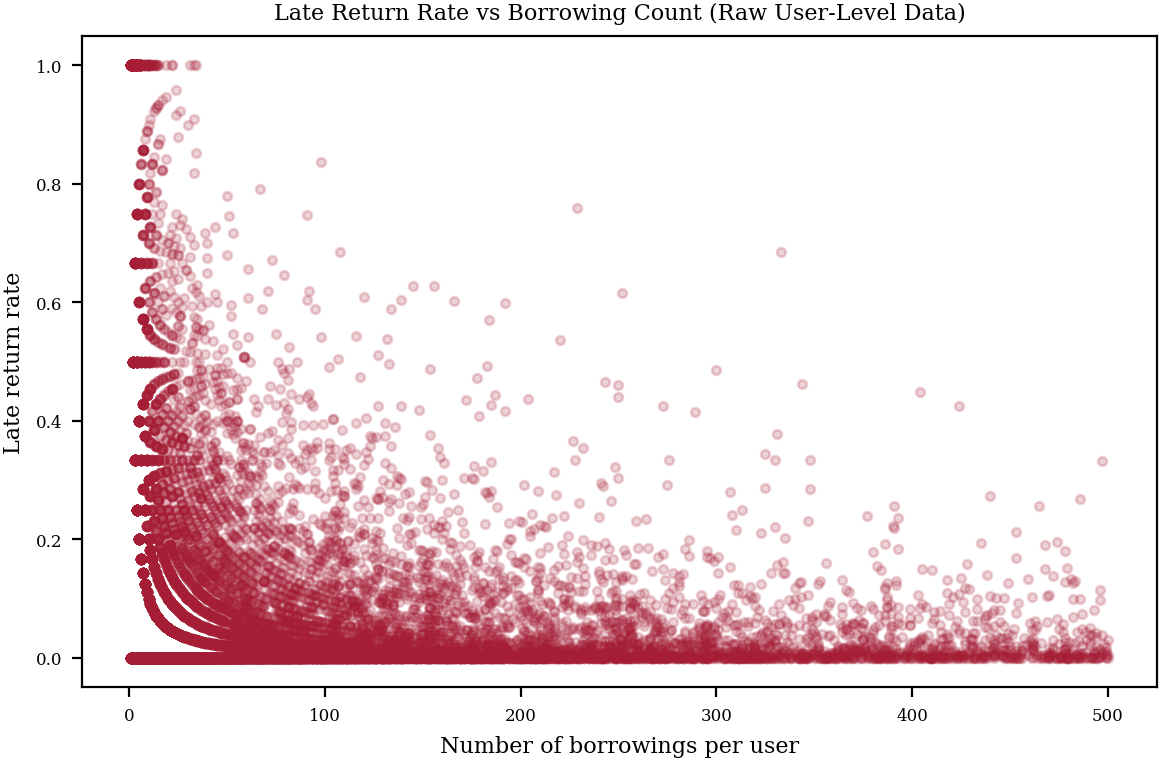

In [181]:
# --- analyze late return rate by borrowing intensity ---

plt.figure(figsize=(6, 4))
plt.scatter(
    borrowings_user["n_borrowings"],
    borrowings_user["late_rate"],
    alpha=0.2,
    s=10
)
plt.xlabel("Number of borrowings per user")
plt.ylabel("Late return rate")
plt.title("Late Return Rate vs Borrowing Count (Raw User-Level Data)")
plt.tight_layout()
plt.show()


As expected, the raw user-level relationship between borrowing frequency and late return rates is highly noisy for users with few borrowings, reflecting small-sample variability. The variance decreases substantially with increasing borrowing count, motivating aggregation into borrowing-frequency bins to reveal systematic trends.


/var/folders/zc/502jnxhs5bx_38b0r7xb68xm0000gn/T/ipykernel_74828/1674866852.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("borrowing_bin")


,mean_late_rate,n_users
borrowing_bin,,
1–5,0.1150,3138
6–10,0.1034,2158
11–20,0.0884,2584
21–50,0.0819,3717
51–100,0.0625,2713
101–200,0.0544,2468
201–500,0.0379,2228


/var/folders/zc/502jnxhs5bx_38b0r7xb68xm0000gn/T/ipykernel_74828/1674866852.py:39: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


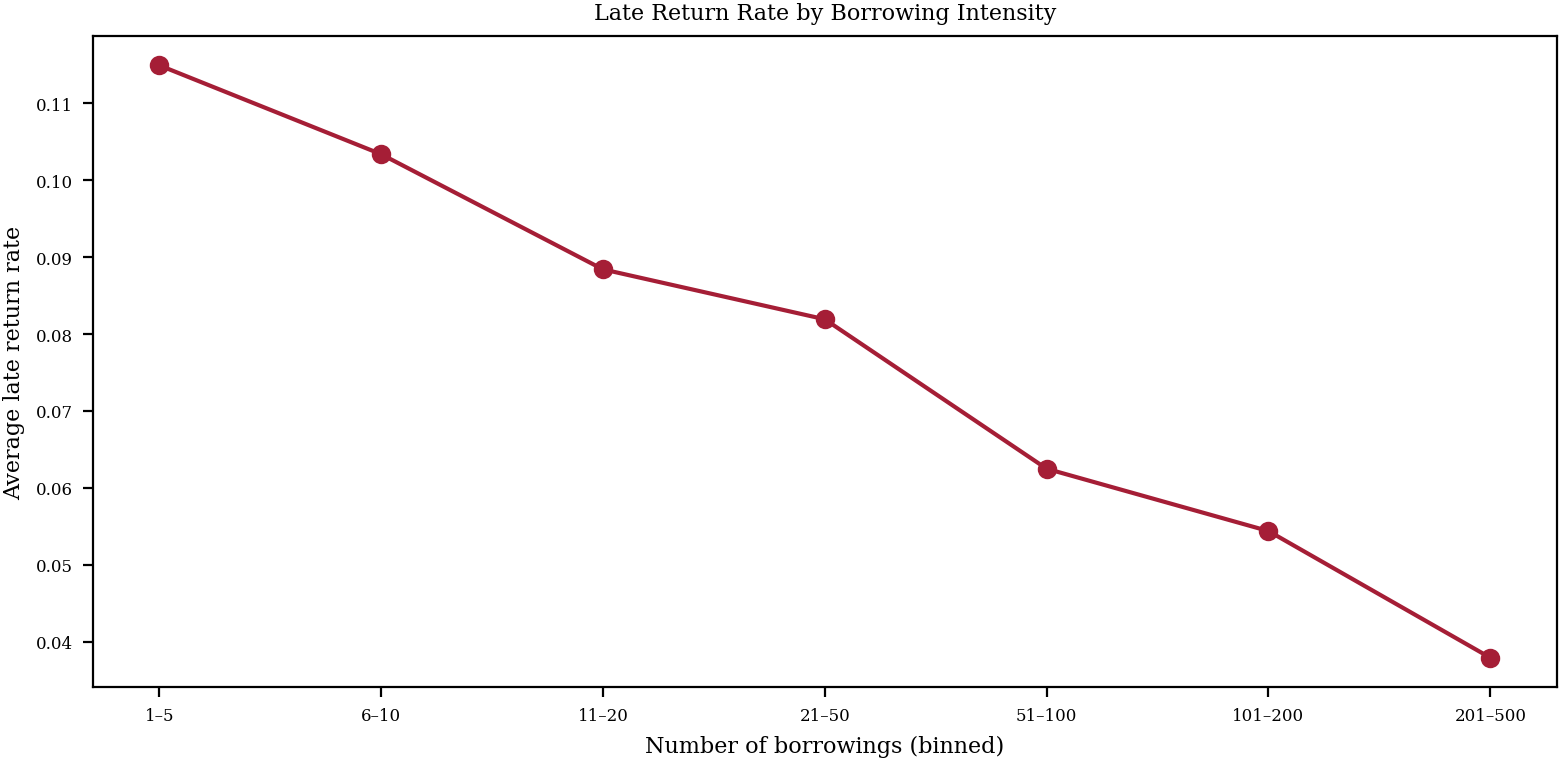

In [182]:
# --- analyze late return rate by borrowing intensity ---

# work on the filtered user-level table
df_borrowing_intensity = borrowings_user.copy()

# define borrowing-intensity bins
bins = [1, 5, 10, 20, 50, 100, 200, 500]
labels = ["1–5", "6–10", "11–20", "21–50", "51–100", "101–200", "201–500"]

df_borrowing_intensity["borrowing_bin"] = pd.cut(
    df_borrowing_intensity["n_borrowings"],
    bins=bins,
    labels=labels,
    right=True
)

# aggregate late rate per bin
bin_summary = (
    df_borrowing_intensity
    .groupby("borrowing_bin")
    .agg(
        mean_late_rate=("late_rate", "mean"),
        n_users=("late_rate", "count")
    )
)

display(bin_summary)

# plot
plt.figure(figsize=(8, 4))
plt.plot(
    bin_summary.index.astype(str),
    bin_summary["mean_late_rate"],
    marker="o"
)
plt.xlabel("Number of borrowings (binned)")
plt.ylabel("Average late return rate")
plt.title("Late Return Rate by Borrowing Intensity")
plt.tight_layout()
plt.show()


The plot shows a clear and monotonic decrease in late return rates with increasing borrowing intensity. Users with few borrowings exhibit the highest late rates, while frequent borrowers are substantially less likely to return items late. This pattern is consistent with a learning or experience effect: as users borrow more often, they appear to manage loan deadlines more reliably. The smooth trend across bins suggests that this relationship reflects systematic behavioral differences rather than random noise.

## Learning over Time within Users

Previous analyses show that frequent borrowers have substantially lower late return rates than occasional users. However, this cross-sectional pattern does not reveal whether this difference reflects learning over time or pre-existing differences between users.

To address this, we examine how late return behavior evolves *within individual users* across their borrowing history. Importantly, experience is defined at the level of **borrowing sessions** rather than individual items, so that multiple items borrowed at the same time are treated as a single experience step. This avoids artificially inflating experience when several items are borrowed in one visit, while still allowing late returns to be measured at the item level.

This approach enables a more meaningful assessment of whether borrowing reliability improves with accumulated experience.


In [183]:
# --- analyze learning effect over time ---

df_user_sessions = borrowings.copy()

# define a borrowing "session" as same user + same issue timestamp 
df_user_sessions["issue_session"] = df_user_sessions[ISSUE_COL].dt.floor("D")  # change to ISSUE_COL

# ngroup is global; convert to per-user consecutive numbering
df_user_sessions["session_index"] = (
    df_user_sessions
    .groupby(USER_ID_COL)["issue_session"]
    .transform(lambda s: pd.factorize(s, sort=True)[0] + 1)
)


In [184]:
EXPERIENCE_CUTOFF = 3

df_learning = df_user_sessions.copy()

df_learning["experience_stage"] = np.where(
    df_learning["session_index"] <= EXPERIENCE_CUTOFF,
    "early",
    "experienced"
)

df_learning["experience_stage"].value_counts()


experience_stage
experienced    2046735
early           266337
Name: count, dtype: int64

In [185]:
stage_late_rate = (
    df_learning
    .groupby("experience_stage")["late_bool"]
    .mean()
)

stage_late_rate

experience_stage
early         0.0626
experienced   0.0390
Name: late_bool, dtype: Float64

/var/folders/zc/502jnxhs5bx_38b0r7xb68xm0000gn/T/ipykernel_74828/4230281300.py:7: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


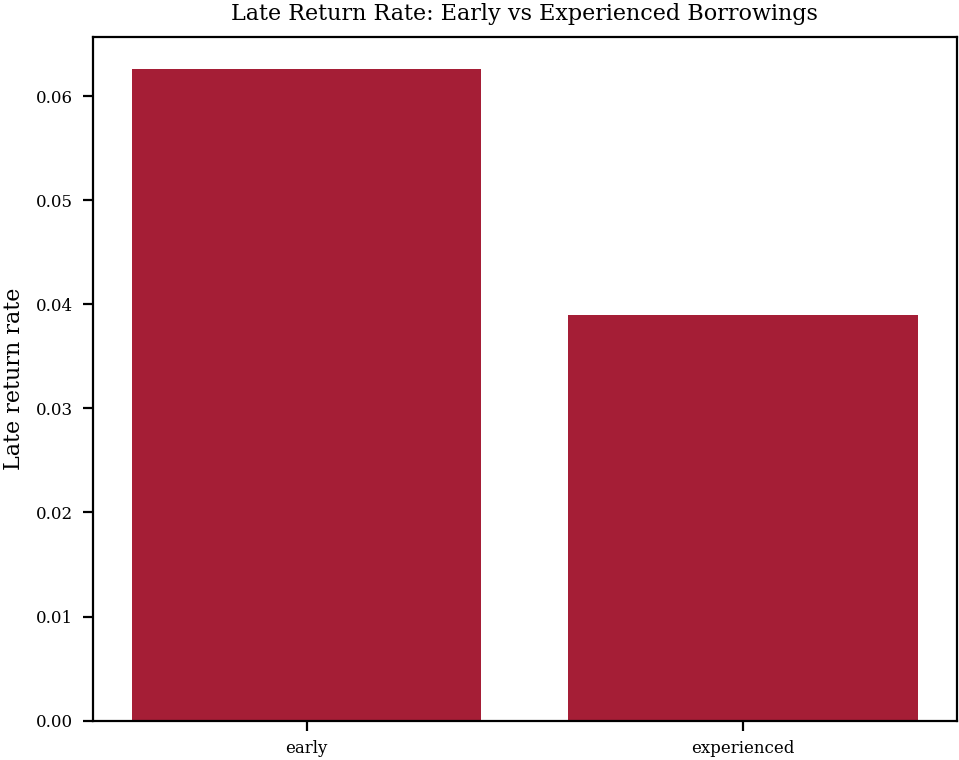

In [186]:
# -- plot late rate by experience stage ---

plt.figure(figsize=(5, 4))
plt.bar(stage_late_rate.index, stage_late_rate.values)
plt.ylabel("Late return rate")
plt.title("Late Return Rate: Early vs Experienced Borrowings")
plt.tight_layout()
plt.show()

The late return rate is substantially higher for early borrowings than for later borrowings of the same users. This decline provides strong evidence of a learning or adaptation effect, whereby users become more reliable as they gain borrowing experience.


## Larning curves

In [187]:
df_curve = df_learning.copy()

# --- compute learning curve ---
learning_curve = (
    df_curve
    .groupby("session_index")["late_bool"]
    .agg(
        late_rate="mean",
        n_obs="count"
    )
    .reset_index()
)

learning_curve.head()

# --- restrict to session indices with sufficient observations ---
MIN_OBS = 3000

max_session = (
    learning_curve
    .loc[learning_curve["n_obs"] >= MIN_OBS, "session_index"]
    .max()
)

print("Max session index with sufficient observations:", max_session)

learning_curve = learning_curve.loc[
    learning_curve["session_index"] <= max_session
].copy()

learning_curve.head()



Max session index with sufficient observations: 100.0


,session_index,late_rate,n_obs
0,1.0000,0.0654,102143
1,2.0000,0.0610,86031
2,3.0000,0.0607,78163
3,4.0000,0.0590,72184
4,5.0000,0.0579,66973


/var/folders/zc/502jnxhs5bx_38b0r7xb68xm0000gn/T/ipykernel_74828/1425940956.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


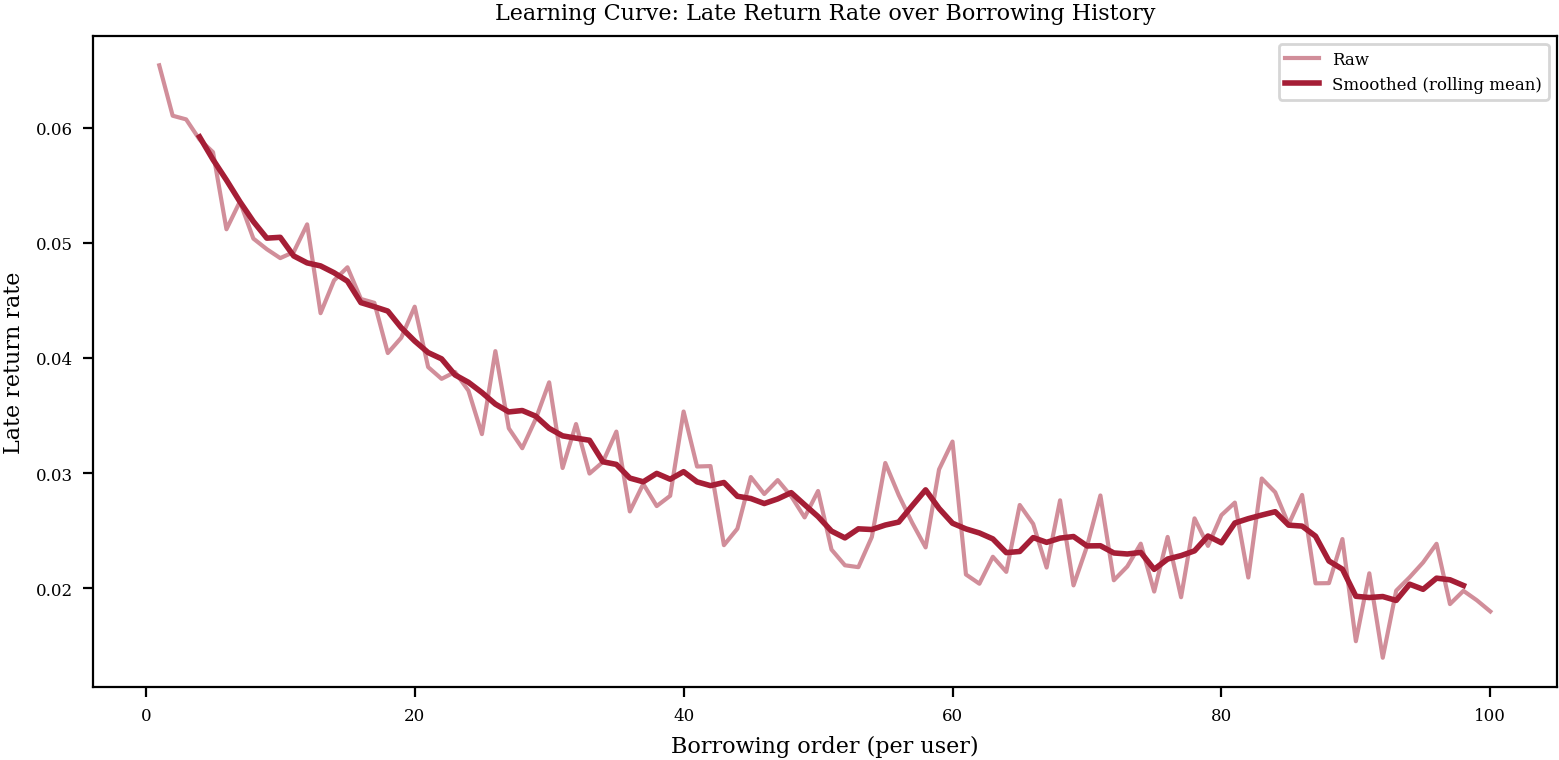

In [188]:
# -- plot learning curve ---

learning_curve["late_rate_smooth"] = (
    learning_curve["late_rate"]
    .rolling(window=6, center=True)
    .mean()
)

plt.figure(figsize=(8, 4))
plt.plot(
    learning_curve["session_index"],
    learning_curve["late_rate"],
    alpha=0.5,
    label="Raw"
)
plt.plot(
    learning_curve["session_index"],
    learning_curve["late_rate_smooth"],
    linewidth=2,
    label="Smoothed (rolling mean)"
)
plt.xlabel("Borrowing order (per user)")
plt.ylabel("Late return rate")
plt.title("Learning Curve: Late Return Rate over Borrowing History")
plt.legend()
plt.tight_layout()
plt.show()

In [189]:
z = 1.96  # 95% CI

learning_curve["ci_lower"] = (
    learning_curve["late_rate"]
    - z * np.sqrt(
        learning_curve["late_rate"] * (1 - learning_curve["late_rate"])
        / learning_curve["n_obs"]
    )
)

learning_curve["ci_upper"] = (
    learning_curve["late_rate"]
    + z * np.sqrt(
        learning_curve["late_rate"] * (1 - learning_curve["late_rate"])
        / learning_curve["n_obs"]
    )
)



learning_curve["ci_lower"] = learning_curve["ci_lower"].clip(0, 1)
learning_curve["ci_upper"] = learning_curve["ci_upper"].clip(0, 1)


/var/folders/zc/502jnxhs5bx_38b0r7xb68xm0000gn/T/ipykernel_74828/3332203295.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


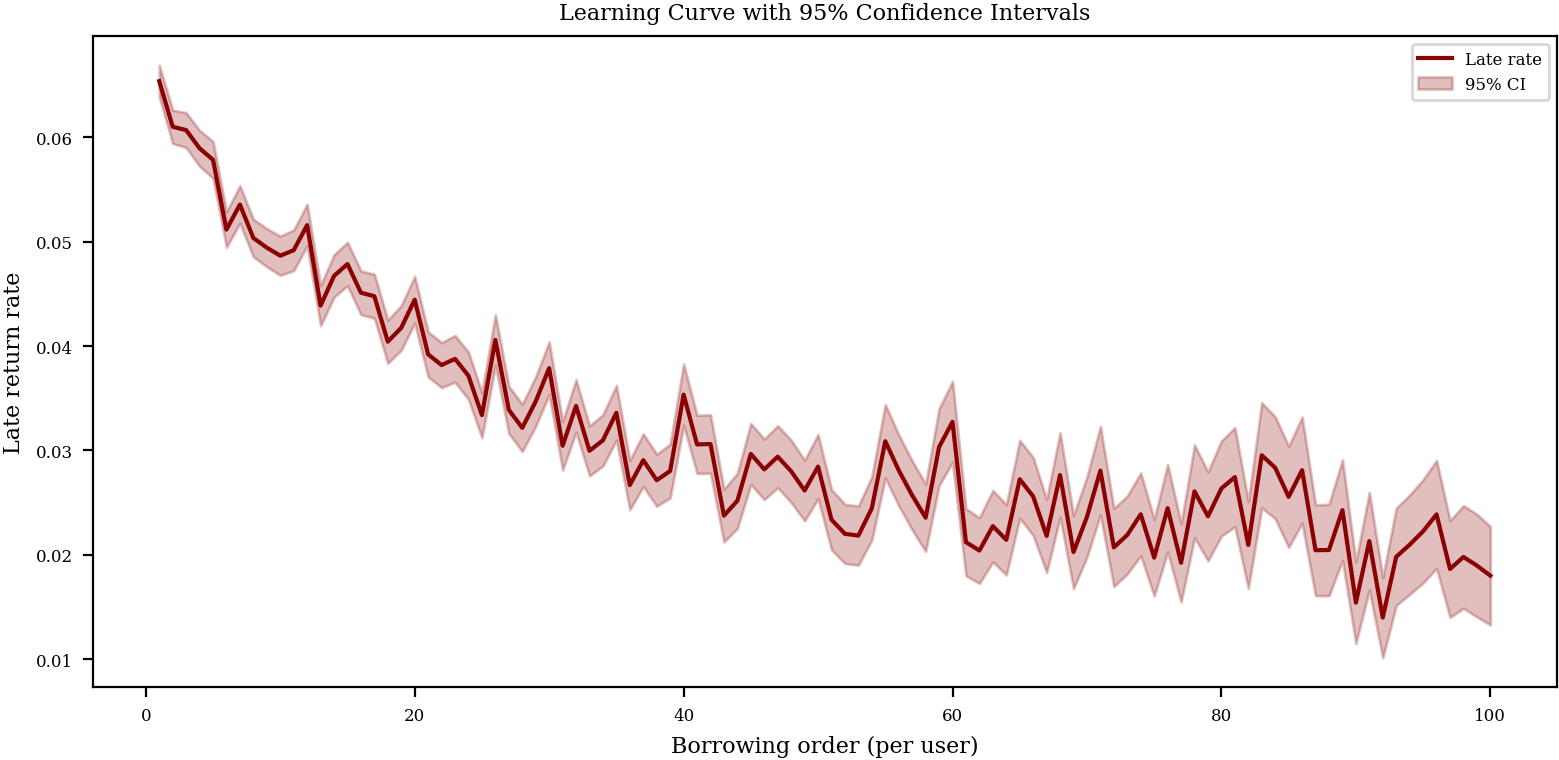

In [190]:
plt.figure(figsize=(8, 4))

plt.plot(
    learning_curve["session_index"],
    learning_curve["late_rate"],
    label="Late rate",
    color="darkred"
)

plt.fill_between(
    learning_curve["session_index"],
    learning_curve["ci_lower"],
    learning_curve["ci_upper"],
    alpha=0.25,
    label="95% CI",
    color="darkred"
)

plt.xlabel("Borrowing order (per user)")
plt.ylabel("Late return rate")
plt.title("Learning Curve with 95% Confidence Intervals")
plt.legend()
plt.tight_layout()
plt.show()


## Does learning differ in User Categories

/var/folders/zc/502jnxhs5bx_38b0r7xb68xm0000gn/T/ipykernel_74828/4038412149.py:68: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


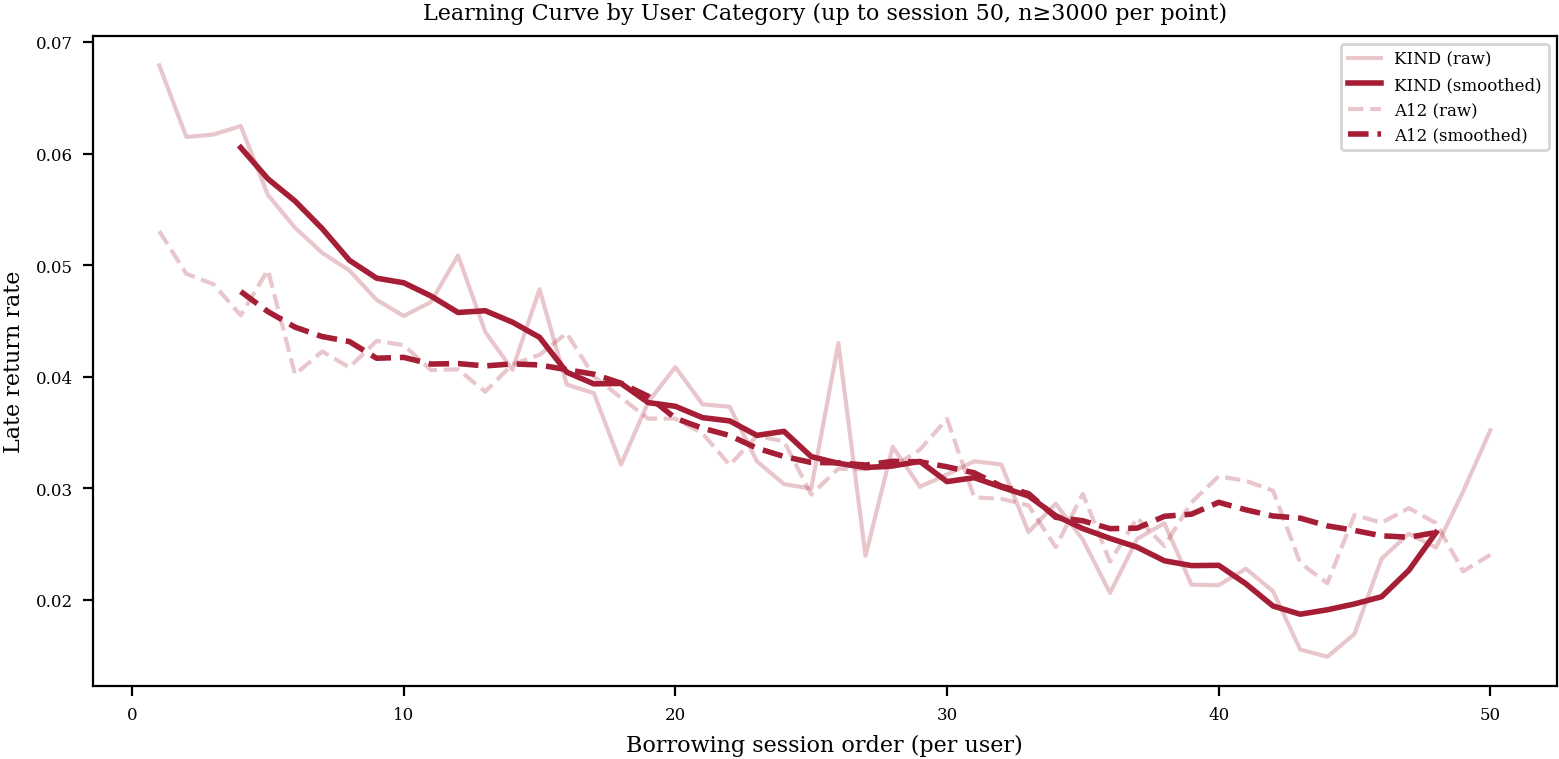

In [191]:
# --- learning curves by user category: KIND vs A12 ---

CATS = ["KIND", "A12"]
MIN_OBS = 3000
SMOOTH_WINDOW = 6

df_cat = df_learning[df_learning[USER_CATEGORY_COL].isin(CATS)].copy()

# aggregate per (category, session_index)
curve_cat = (
    df_cat
    .groupby([USER_CATEGORY_COL, "session_index"])["late_bool"]
    .agg(late_rate="mean", n_obs="count")
    .reset_index()
)

# find max session_index with enough observations per category
max_sessions = (
    curve_cat[curve_cat["n_obs"] >= MIN_OBS]
    .groupby(USER_CATEGORY_COL)["session_index"]
    .max()
)

# use a common cutoff for fair comparison (min of both)
common_max = int(max_sessions.min()) if len(max_sessions) == len(CATS) else None
if common_max is None:
    raise ValueError(f"Not all categories reach MIN_OBS={MIN_OBS}. Available: {max_sessions.to_dict()}")

curve_cat = curve_cat[curve_cat["session_index"] <= common_max].copy()

# smooth within each category
curve_cat["late_rate_smooth"] = (
    curve_cat
    .groupby(USER_CATEGORY_COL)["late_rate"]
    .transform(lambda s: s.rolling(window=SMOOTH_WINDOW, center=True).mean())
)

# --- plot ---
plt.figure(figsize=(8, 4))

linestyles = {"KIND": "-", "A12": "--"}

for cat in CATS:
    d = curve_cat[curve_cat[USER_CATEGORY_COL] == cat]

    # raw (faint)
    plt.plot(
        d["session_index"],
        d["late_rate"],
        alpha=0.25,
        linestyle=linestyles[cat],
        label=f"{cat} (raw)"
    )

    # smoothed (strong)
    plt.plot(
        d["session_index"],
        d["late_rate_smooth"],
        linewidth=2,
        linestyle=linestyles[cat],
        label=f"{cat} (smoothed)"
    )

plt.xlabel("Borrowing session order (per user)")
plt.ylabel("Late return rate")
plt.title(f"Learning Curve by User Category (up to session {common_max}, n≥{MIN_OBS} per point)")
plt.legend()
plt.tight_layout()
plt.show()


## Number of loans per session and late return

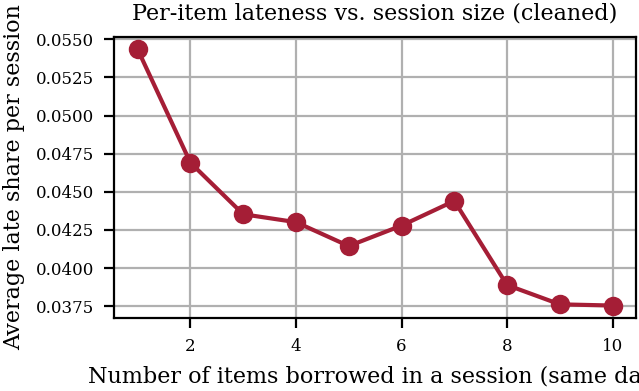

,n_items,mean_late_share,n_sessions
0,1,0.0543,105253
1,2,0.0469,71140
2,3,0.0435,55464
3,4,0.0430,43582
4,5,0.0414,33563
5,6,0.0428,26158
6,7,0.0444,19780
7,8,0.0389,15911
8,9,0.0376,12466
9,10,0.0375,10340


In [ ]:
# --- analyze per-item lateness vs. session size ---
df_session_clean = (
    df_user_sessions
    .groupby([USER_ID_COL, "issue_session"])
    .agg(
        n_items=("late_bool", "size"),
        n_late=("late_bool", "sum")   # True counts as 1
    )
    .reset_index()
)

# drop sessions with unknown lateness
df_session_clean = df_session_clean.dropna(subset=["n_late"])

df_session_clean["late_share"] = (
    df_session_clean["n_late"] / df_session_clean["n_items"]
)

# limit large sessions to reduce noise
df_session_clean = df_session_clean[df_session_clean["n_items"] <= 10]

# Average late share by session size
df_late_share_by_size = (
    df_session_clean
    .groupby("n_items")
    .agg(
        mean_late_share=("late_share", "mean"),
        n_sessions=("late_share", "size")
    )
    .reset_index()
)

# Plot
plt.figure()
plt.plot(
    df_late_share_by_size["n_items"],
    df_late_share_by_size["mean_late_share"],
    marker="o"
)
plt.xlabel("Number of items borrowed in a session (same day)")
plt.ylabel("Average late share per session")
plt.title("Per-item lateness vs. session size (cleaned)")
plt.grid(True)
plt.show()

df_late_share_by_size